In [3]:
from tqdm.auto import tqdm
import numpy as np
import tensorflow as tf
from causal_util.collect_data import EnvDataCollector
from matplotlib import pyplot as plt
import os
import sys
from sparse_causal_model_learner_rl.learner import Learner
import gin
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.config.config import Config
from sparse_causal_model_learner_rl.trainable.decoder import IdentityDecoder
import pickle
%matplotlib inline

load_config_files(['../keychest/config/5x5.gin', '../sparse_causal_model_learner_rl/configs/common.gin'])

['5x5', 'common']

In [4]:
learner = Learner(Config())

Make environment KeyChest-v0 None {}


In [5]:
def get_xy_conv(steps=1000, orig_shape=True):
    """Get the dataset."""
    gin.bind_parameter('Config.feature_shape', None)
    gin.bind_parameter('KeyChestEnvironment.flatten_observation', not orig_shape)
    gin.bind_parameter('Config.env_steps', steps)
    gin.bind_parameter('Config.decoder', None)
    gin.bind_parameter('Config.model', None)
    gin.bind_parameter('Config.reconstructor', None)
    gin.bind_parameter('Config.value_predictor', None)
    gin.bind_parameter('Config.disable_cuda', True)
    learner = Learner(Config())
    learner.collect_steps(do_tqdm=True)
    obs_x = learner._context.get('obs_x').cpu().numpy()
    obs_y = learner._context.get('obs_y').cpu().numpy()
    act_x = learner._context.get('action_x').cpu().numpy()
    
    if orig_shape:
        return obs_x, act_x, obs_y
    else:
        X = np.concatenate((obs_x, act_x), axis=1)
        y = obs_y
        return X, y

In [6]:
Xo_train, Xa_train, yo_train = get_xy_conv(steps=100000, orig_shape=True)

Make environment KeyChest-v0 None {}


In [7]:
Xa_train

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [8]:
env = learner.env
h, w, c = env.engine._observation.shape

In [9]:
h, w, c

(12, 7, 11)

In [10]:
learner.env.engine

In [11]:
obss = Xo_train

In [12]:
engine = learner.env.engine

In [13]:
def obss_to_rgb(obss, engine=engine):
    """Convert an array with observations to RGB, supporting multiple items per pixel."""
    howmany = (1e-10 + np.sum(obss, axis=3)[:, :, :, np.newaxis])
    print(np.max(howmany))
    obss = obss / howmany
    colors_to_rgb = np.array([engine.COLORS[o] for o in engine.OBJECTS]) / 255.
    obss_rgb = obss @ colors_to_rgb
    return obss_rgb

In [14]:
def rgb_pad(obss_rgb):
    b, x, y, c = obss_rgb.shape
    x1 = max(x, 16)
    y1 = max(y, 8)
    out = np.zeros((b, x1, y1, c), dtype=obss_rgb.dtype)
    out[:, :x, :y, :] = obss_rgb
    return out

In [15]:
obss_rgb = obss_to_rgb(obss)
obss_rgb = rgb_pad(obss_rgb)

3.0


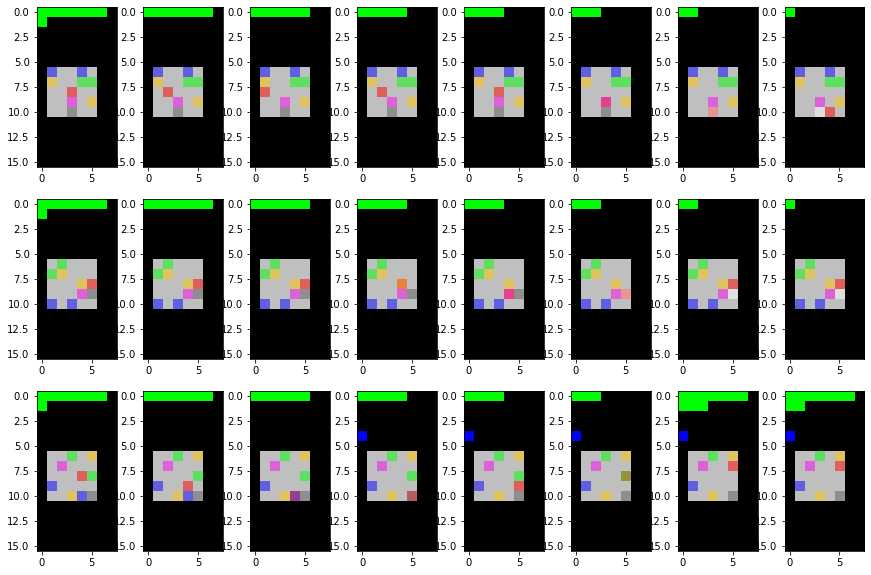

In [16]:
gx = 3
gy = 8

plt.figure(figsize=(15, 10))

idx_start = np.random.choice(len(obss_rgb) - gx * gy - 1)

for i in range(gx * gy):
    plt.subplot(gx, gy, i + 1)
    plt.imshow(obss_rgb[idx_start + i])

In [96]:
#  see https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader
from torch.utils.data import TensorDataset, DataLoader
import torch

Xo_train_torch = torch.Tensor(np.rollaxis(rgb_pad(obss_to_rgb(Xo_train)), 3, 1))
Xa_train_torch = torch.Tensor(Xa_train)
yo_train_torch = torch.Tensor(np.rollaxis(rgb_pad(obss_to_rgb(yo_train)), 3, 1))

my_dataset = TensorDataset(Xo_train_torch, Xa_train_torch, yo_train_torch) # create your datset
# my_dataset = TensorDataset(Xo_train_torch, Xa_train_torch, Xo_train_torch) # PURE RECONSTRUCTION
my_dataloader = DataLoader(my_dataset, batch_size=512, shuffle=True)#False) # create your dataloader

3.0
3.0


In [97]:
Xo_train_torch.shape

torch.Size([91600, 3, 16, 8])

In [145]:
#!/usr/bin/env python
# taken from https://github.com/bharatprakash/vae-dynamics-model/blob/master/env_model/obs_model.py
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from PIL import Image
import sys
import os
import numpy as np

img_x = 16
img_y = 8

def to_img(x):
    x = x.view(x.size(0), 3, img_x, img_y)
    return x

def to_onehot(size, value):
    my_onehot = np.zeros((size))
    my_onehot[value] = 1.0
    return my_onehot


class ObsNet(nn.Module):
    def __init__(self, intermediate_size, hidden_size, hidden_size2):
        super(ObsNet, self).__init__()
        # Encoder
        
        self.hid_x = 8
        self.hid_y = 4
        
        
        layer_kwargs = [
            dict(kernel_size=3, stride=1, padding=1),
            dict(kernel_size=2, stride=2, padding=0),
            dict(kernel_size=3, stride=1, padding=1),
            dict(kernel_size=3, stride=1, padding=1),
        ]
        
        self.channels = [3, 3, 32, 32, 32]
        
        assert len(layer_kwargs) == len(self.channels) - 1
        
        for i in range(1, len(layer_kwargs) + 1):
            setattr(self, 'conv%d' % i, nn.Conv2d(self.channels[i - 1], self.channels[i], **layer_kwargs[i - 1]))
        
        # space before computing mean and logstd
        self.fc1 = nn.Linear(self.hid_x * self.hid_y * self.channels[-1], intermediate_size)
        
        # Latent space
        self.fc21 = nn.Linear(intermediate_size, hidden_size)
        self.fc22 = nn.Linear(intermediate_size, hidden_size)

        # Decoder
        self.fc3 = nn.Linear(hidden_size2, intermediate_size)
        self.fc4 = nn.Linear(intermediate_size, self.hid_x * self.hid_y * self.channels[-1])
        
        for i in range(1, len(layer_kwargs))[::-1]:
            setattr(self, 'deconv%d' % i, nn.ConvTranspose2d(self.channels[i + 1], self.channels[i], **layer_kwargs[i]))
        
        self.conv_last = nn.Conv2d(self.channels[1], self.channels[0], **layer_kwargs[0])

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.relu(self.conv3(out))
        out = self.relu(self.conv4(out))
        assert out.shape[-2:] == (self.hid_x, self.hid_y), (out.shape, self.hid_x, self.hid_y)
#         print(out.shape)
        out = out.view(out.size(0), -1)
#         print(out.shape)
        h1 = self.relu(self.fc1(out))
        return h1, self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        out = self.relu(self.fc4(h3))
#         print(h3.shape)
        out = out.view(out.size(0), self.channels[-1], self.hid_x, self.hid_y)
        out = self.relu(self.deconv3(out))
        out = self.relu(self.deconv2(out))
        out = self.relu(self.deconv1(out))
        out = self.sigmoid(self.conv_last(out))
        return out

    def forward(self, x, a):
        h1, mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        za = torch.cat([z,a], 1)
        return self.decode(za), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        assert recon_x.shape == x.shape
        BCE = F.binary_cross_entropy(recon_x.view(-1, img_x * img_y * self.channels[0]),
                                     x.view(-1, img_x * img_y * self.channels[0]), size_average=False) # does not work without size_average=False???
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD


class ObsModel(object):
    def __init__(self):
        self.model = ObsNet(128,20,24).cuda()
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        self.train_loader = my_dataloader


    def train(self, epochs):
        self.model.train()
        for epoch in range(1, epochs + 1):
            train_loss = 0
            train_mae = 0
            for i, (states, actions, next_states) in enumerate(self.train_loader):

                states = Variable(states).cuda()
                next_states = states# Variable(next_states).cuda()
                actions = Variable(actions).cuda()

                self.optimizer.zero_grad()
                recon_batch, mu, logvar = self.model(states, actions)
                loss = self.model.loss_function(recon_batch, next_states, mu, logvar)
                loss.backward()
                train_loss += loss.item()
                self.optimizer.step()
                train_mae += torch.nn.L1Loss()(recon_batch, next_states)

            if epoch % 1 == 0:
                N = len(m.train_loader) * m.train_loader.batch_size
                print('====> Epoch: {} Average loss: {} MAE: {}'.format(
                      epoch, train_loss/N, train_mae / len(m.train_loader)))
#             if epoch % 50 == 0:
#                 torch.save(self.model.state_dict(), './saved_models/obs_model.pth')

    def predict(self, state, action):
        self.model.eval()
        state = Variable(torch.Tensor(state.reshape((1,3,img_x, img_y)))).cuda()
        action = to_onehot(4, action)
        action = Variable(torch.Tensor(action.reshape((1, 4)))).cuda()
        next_state, mu, logvar = self.model(state, action)
        return next_state

In [146]:
m = ObsModel()

In [ ]:
m.train(epochs=1000)

====> Epoch: 1 Average loss: 90.36486417887598 MAE: 0.110744908452034
====> Epoch: 2 Average loss: 53.143820352394485 MAE: 0.03633793070912361
====> Epoch: 3 Average loss: 50.49661627828076 MAE: 0.029045887291431427
====> Epoch: 4 Average loss: 49.946201068728996 MAE: 0.02728034369647503
====> Epoch: 5 Average loss: 49.684674907663016 MAE: 0.026324596256017685
====> Epoch: 6 Average loss: 49.485834579894 MAE: 0.025632526725530624
====> Epoch: 7 Average loss: 49.373414194117714 MAE: 0.025154974311590195
====> Epoch: 8 Average loss: 49.30324215595949 MAE: 0.02484627068042755
====> Epoch: 9 Average loss: 49.220292352431315 MAE: 0.024584097787737846
====> Epoch: 10 Average loss: 49.172166387462084 MAE: 0.024378566071391106
====> Epoch: 11 Average loss: 49.135994426365 MAE: 0.02421088144183159
====> Epoch: 12 Average loss: 49.099842881357205 MAE: 0.024079307913780212
====> Epoch: 13 Average loss: 49.09764719275789 MAE: 0.023998931050300598


In [124]:
m.model.eval()

ObsNet(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(3, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc21): Linear(in_features=128, out_features=20, bias=True)
  (fc22): Linear(in_features=128, out_features=20, bias=True)
  (fc3): Linear(in_features=24, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=1024, bias=True)
  (deconv1): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv3): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv5): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [125]:
_, (states, actions, next_states) = next(enumerate(m.train_loader))

In [126]:
states.shape

torch.Size([512, 3, 16, 8])

In [127]:
states = Variable(states).cuda()
actions = Variable(actions).cuda()
next_states = Variable(next_states).cuda()

In [128]:
out, _, _ = m.model(states, actions)

In [129]:
np.mean(np.abs((out - next_states).detach().cpu().numpy()))

0.02486904

In [130]:
out_img = out.detach().cpu().numpy()

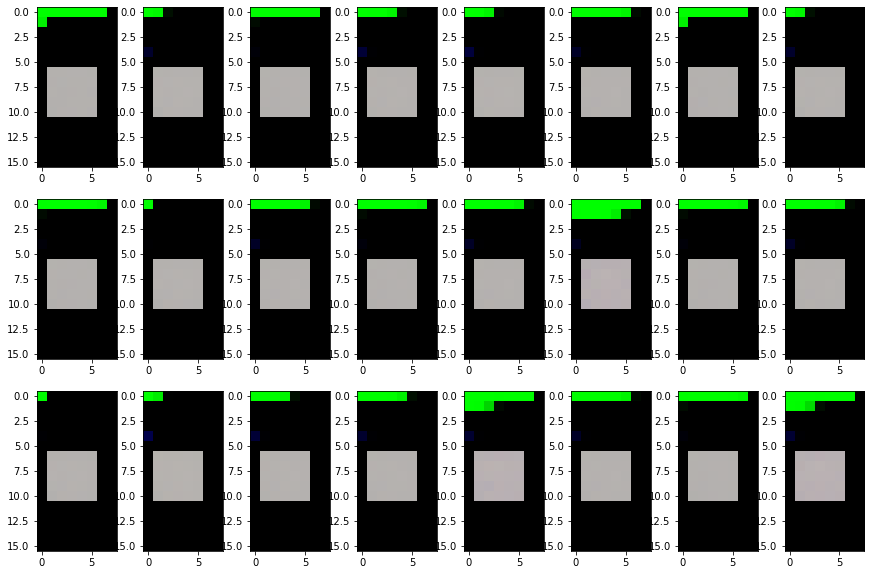

In [131]:
gx = 3
gy = 8

plt.figure(figsize=(15, 10))

idx_start = np.random.choice(len(out_img) - gx * gy - 1)

for i in range(gx * gy):
    plt.subplot(gx, gy, i + 1)
    plt.imshow(np.rollaxis(out_img[idx_start + i], 0, 3))

(array([2.7779999e+07, 0.0000000e+00, 1.4900000e+04, 1.0136370e+06,
        0.0000000e+00, 2.6705300e+05, 0.0000000e+00, 4.8203970e+06,
        7.4541300e+05, 5.3300100e+05]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

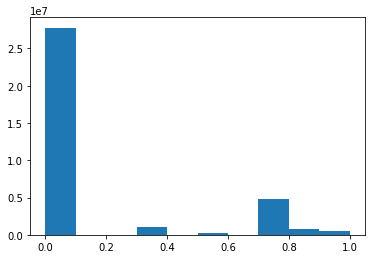

In [122]:
plt.hist(Xo_train_torch.numpy().flatten())